<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_LSTM_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective

**Use a deep learning driven approach to build a crude palm oil preice predictor that takes monthly data over a certain date range as input, and outputs projected estimates for different time ranges in the future.**

In [ ]:
!pip install keras_tuner
!pip install tensorflow
!pip install keras-tuner --upgrade

###Load Libraries

In [146]:
import pandas as pd
import math
import keras
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from kerastuner import BayesianOptimization
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import keras_tuner
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)

###Define Functions to Facilitate Metrics Evaluation

In [112]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [113]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [114]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

###Split Data into Train Test Segments

In [115]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 207
Test size: 23


###Plot Train Test Data

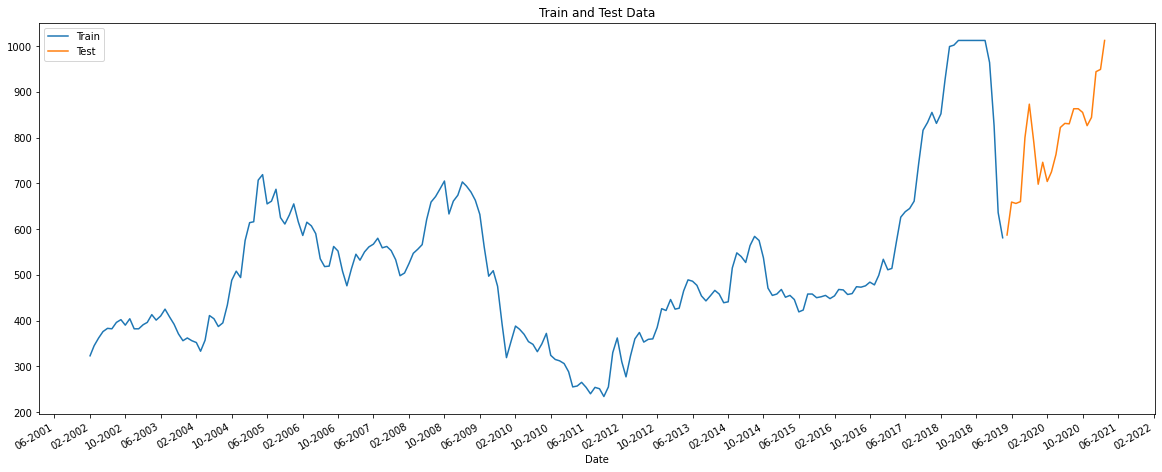

In [116]:
#Plotting data
plt.figure(figsize=(20,8))
plt.title("Train and Test Data")
plt.plot(train.index, train['cpo_pri'], label='Train')
plt.plot(test.index, test['cpo_pri'], label='Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=8))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [117]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

207 23


In [118]:
print(train.shape)
train.head()

(207, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [123]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,0.114359,0.210429,0.013238,0.218695,0.265091,0.109026
2002-03-01,0.142628,0.323070,0.005303,0.183797,0.289974,0.044200
2002-04-01,0.164472,0.383723,0.000000,0.120980,0.262164,0.006514
2002-05-01,0.182461,0.434473,0.004228,0.040327,0.227035,0.000000
2002-06-01,0.191455,0.560730,0.042041,0.044204,0.208007,0.010236


In [124]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01    0.114359
2002-03-01    0.142628
2002-04-01    0.164472
2002-05-01    0.182461
2002-06-01    0.191455
Name: cpo_pri, dtype: float64

In [125]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2019-05-01,0.453582,0.563206,0.422889,0.930375,0.671342,0.331576
2019-06-01,0.546097,0.555779,0.448122,0.820392,0.736243,0.364144
2019-07-01,0.542242,0.480272,0.453614,0.760965,0.674401,0.415167
2019-08-01,0.547382,0.420857,0.487240,0.754745,0.649621,0.462314
2019-09-01,0.727273,0.571871,0.513956,0.675472,0.764331,0.545751


In [126]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2019-05-01    0.453582
2019-06-01    0.546097
2019-07-01    0.542242
2019-08-01    0.547382
2019-09-01    0.727273
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [129]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 2
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(205, 2, 6) (205,)


### LSTM Architecture

In [130]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.Dense(units=1))
lstm_model.compile(loss='mse', optimizer='adam')

In [131]:
lstm_history = lstm_model.fit(X_train, y_train,epochs=50,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/50
6/6 [==============================] - 2s 77ms/step - loss: 0.0746 - val_loss: 0.2914
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0973
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0160 - val_loss: 0.0405
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0152 - val_loss: 0.0411
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0105 - val_loss: 0.0597
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0724
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0660
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.0501
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0376
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0312
Epoch 11/50
6/6 [=====================

In [132]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               69120     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


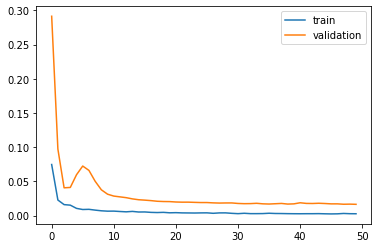

In [133]:
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

**Looking at the plot we can detect overfitting. There is room for improvement.**

### Apply Random Search to get Best Hyperparameters

In [ ]:
'''
def build_model(hp):
    model = Sequential()
    #model = keras.Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train.shape[0], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model
'''

In [134]:
def build_model(hp):

    model = Sequential()

    model.add(LSTM(hp.Int('input_units',
                          min_value=32,
                          max_value=256,
                          step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))

    #model.add(LSTM(hp.Int('secondary_units',
                          #min_value=32,
                          #max_value=128,
                          #step=32),
                   #return_sequences=False))

    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))

    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(Dense(hp.Int(f'dense_{i}_units',
                               min_value=8,
                               max_value=32,
                               step=8)))

    model.add(Dense(y_train.shape))

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    return model

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="mse",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [136]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layer_2_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
lstm_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
lstm_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}


In [137]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [138]:
tuner.get_best_hyperparameters()[0].values

{'Dropout_rate': 0.0,
 'dense_activation': 'sigmoid',
 'input_unit': 288,
 'layer_2_neurons': 96,
 'lstm_0_units': 128,
 'lstm_1_units': 512,
 'lstm_2_units': 64,
 'n_layers': 1}

In [139]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
input_unit: 288
n_layers: 1
lstm_0_units: 128
layer_2_neurons: 96
Dropout_rate: 0.0
dense_activation: sigmoid
lstm_1_units: 512
lstm_2_units: 64
Score: 0.0108967418782413
Trial summary
Hyperparameters:
input_unit: 64
n_layers: 1
lstm_0_units: 256
layer_2_neurons: 64
Dropout_rate: 0.1
dense_activation: relu
lstm_1_units: 352
lstm_2_units: 448
Score: 0.02417697384953499
Trial summary
Hyperparameters:
input_unit: 64
n_layers: 3
lstm_0_units: 320
layer_2_neurons: 32
Dropout_rate: 0.30000000000000004
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 32
Score: 0.03316141199320555


###Apply Bayesian Optimization

In [153]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('units',min_value=8,
                                        max_value=64,
                                        step=8), 
                   activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dense(1))

    model.compile(loss='mse', optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                   metrics=['mse'])
    return model

In [154]:
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

bayesian_opt_tuner.search(X_train, y_train,epochs=50,
     #validation_data=(X_test, y_test)
     validation_split=0.2,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

Trial 3 Complete [00h 00m 04s]
mse: 0.06555971503257751

Best mse So Far: 0.0013938846532255411
Total elapsed time: 00h 00m 13s
INFO:tensorflow:Oracle triggered exit


In [155]:
bayesian_opt_tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.01, 'units': 24}

In [156]:
bayesian_opt_tuner.results_summary()

Results summary
Results in C:/keras_tuning/kerastuner_bayesian_poc
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
units: 24
learning_rate: 0.01
Score: 0.0013938846532255411
Trial summary
Hyperparameters:
units: 40
learning_rate: 0.01
Score: 0.0016199385281652212
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.0001
Score: 0.06555971503257751


In [ ]:
def build_model(hp):

    model = Sequential()

    model.add(LSTM(hp.Int('input_units',
                          min_value=32,
                          max_value=256,
                          step=32),
                   input_shape=(X_test.shape[1], X_test.shape[2]),
                   return_sequences=True))

    model.add(LSTM(hp.Int('secondary_units',
                          min_value=32,
                          max_value=128,
                          step=32),
                   return_sequences=False))

    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))

    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(Dense(hp.Int(f'dense_{i}_units',
                               min_value=8,
                               max_value=32,
                               step=8)))

    model.add(Dense(y_train.shape[0]))

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    return model

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('/content/bayes.txt'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

bayesian_opt_tuner.search(X_train, y_train,epochs=200,
     #validation_data=(X_test, y_test)
     validation_split=0.2,verbose=1)

best_model = bayesian_opt_tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
best_model.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.0064 - mse: 0.0064


[0.006448349915444851, 0.006448349915444851]

In [ ]:
def build_model(hp):
    model = Sequential()
    #model = keras.Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [ ]:
model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))

NameError: ignored

In [ ]:
model.fit(X_train, y_train, epochs=300, batch_size=50, verbose=1)

In [ ]:
for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))

NameError: ignored

In [ ]:
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization

n_input = 6

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), 
               activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',
                  values=[1e-2, 1e-3, 1e-4])))
    return model

In [ ]:
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

bayesian_opt_tuner.search(train_x, train_y,epochs=n_epochs,
     #validation_data=(X_test, y_test)
     validation_split=0.2,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]